
# A One Asset HANK Model 

This notebook solves a New Keynesian model in which there is only a single liquid asset.  This is the second model described in <cite data-cite="6202365/ECL3ZAR7"></cite>.  For a detailed description of their solution method, see the companion two-asset HANK model notebook.

In [1]:
# Setup
from __future__ import print_function

# This is a jupytext paired notebook that autogenerates a corresponding .py file
# which can be executed from a terminal command line via "ipython [name].py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 
    
# The tools for navigating the filesystem
import sys
import os

# Find pathname to this file:
my_file_path = os.path.dirname(os.path.abspath("OneAssetHANK.ipynb"))

# Relative directory for pickled code
code_dir = os.path.join(my_file_path, "BayerLuetticke_code/OneAssetCode-HANK") 

sys.path.insert(0, code_dir)
sys.path.insert(0, my_file_path)

In [2]:
# Import external libraries

import numpy as np
from numpy.linalg import matrix_rank
import scipy as sc
from scipy.stats import norm 
from scipy.interpolate import interp1d, interp2d
import multiprocessing as Mp
from multiprocessing import Pool, cpu_count
from math import ceil
import math as mt
from scipy import sparse as sp
from scipy import linalg
from math import log, cos, pi
import time
from SharedFunc2 import Transition, ExTransitions, GenWeight, MakeGrid2, Tauchen
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io
from copy import copy
from time import clock

In [3]:
# Bayer-Luetticke Code

class FluctuationsOneAssetIOUs:
    
    def __init__(self, par, mpar, grid, Output, targets, Vm, joint_distr, Copula, c_policy, m_policy, mutil_c, P_H):
         
        self.par = par
        self.mpar = mpar
        self.grid = grid
        self.Output = Output
        self.targets = targets
        self.Vm = Vm
        self.joint_distr = joint_distr
        self.Copula = Copula
        self.c_policy = c_policy
        self.m_policy = m_policy
        self.mutil_c = mutil_c
        self.P_H = P_H
        
        
    def StateReduc(self):
        invutil = lambda x : ((1-self.par['xi'])*x)**(1./(1-self.par['xi']))
        invmutil = lambda x : (1./x)**(1./self.par['xi'])

        Xss=np.vstack((np.sum(self.joint_distr.copy(),axis=1), np.transpose(np.sum(self.joint_distr.copy(),axis=0)),np.log(self.par['RB']),0))
        Yss=np.vstack((invmutil(np.reshape(self.mutil_c.copy(),(np.product(self.mutil_c.shape),1),order='F')),np.log(self.par['PI']),np.log(self.targets['Y']),np.log(self.targets['W']),np.log(self.targets['PROFITS']),np.log(self.targets['N']),self.targets['B'],self.targets['G']))
        ## Construct Chebyshev Polynomials to describe deviations of policy from SS
        Poly=[]
        maxlevel=max(self.mpar['nm'],self.mpar['nh'])
        
        Tm=np.cos(pi*np.arange(0,maxlevel,1)[np.newaxis].T * (np.linspace(0.5/self.mpar['nm']/2, 1-0.5/self.mpar['nm']*2, self.mpar['nm'])[np.newaxis])).T
        Th=np.cos(pi*np.arange(0,maxlevel,1)[np.newaxis].T * (np.linspace(0.5/(self.mpar['nh']-1), 1-0.5/(self.mpar['nh']-1), (self.mpar['nh']-1))[np.newaxis])).T

        self.mpar['maxdim']=10
        
        for j1 in range(0, max(np.shape(self.grid['h']))-1):
          for j3 in range(0, max(np.shape(self.grid['m']))):
            if j1 + j3 < self.mpar['maxdim']-2:
                TT1,TT3=np.meshgrid(Tm[:,j3], np.vstack((Th[:,j1][np.newaxis].T,0.)), indexing='ij')
                Poly.append((TT1.flatten(order='F')*TT3.flatten(order='F'))[np.newaxis].T)

        for j2 in range(0,max(np.shape(self.grid['m']))):
            if j2 < self.mpar['maxdim']- 2:
               TT1,TT3=np.meshgrid(Tm[:,j2], np.vstack((np.zeros(max(np.shape(self.grid['h']))-1)[np.newaxis].T,1)), indexing='ij')
               Poly.append((TT1.flatten(order='F')*TT3.flatten(order='F'))[np.newaxis].T)

        Poly=np.squeeze(np.asarray(Poly)).T
        InvCheb=linalg.solve(np.dot(Poly.T,Poly),Poly.T)
        
        ## Construct function such that perturbed marginal distributions still integrate to 1
        Gamma=np.zeros((self.mpar['nm'] + self.mpar['nh'], self.mpar['nm'] + self.mpar['nh'] - 3))

        for j in range(0,self.mpar['nm'] - 1):
              Gamma[0:self.mpar['nm'],j]= -np.squeeze(Xss[0:self.mpar['nm']])
              Gamma[j,j]= 1. - Xss[j]
              Gamma[j,j]=Gamma[j,j] - sum(Gamma[0:self.mpar['nm'],j])
        
        bb=self.mpar['nm']
        
        for j in range(0,self.mpar['nh'] - 2):
              Gamma[bb + np.asarray(range(0,self.mpar['nh'] - 1)), bb + j-1]= -np.squeeze(Xss[bb + np.asarray(range(0,self.mpar['nh'] - 1))])
              Gamma[bb + j,bb - 1 + j]= 1 - Xss[bb + j]
              Gamma[bb + j,bb - 1 + j]= Gamma[bb + j,bb - 1 + j] - sum(Gamma[bb + np.asarray(range(0,self.mpar['nh'] - 1)), bb - 1 + j])
  
            ## Collect all functions used for perturbation
        n1=np.array(np.shape(Poly))
        n2=np.array(np.shape(Gamma))

        # Produce matrices to reduce state-space
        oc=len(Yss) - n1[0]
        os=len(Xss) - (self.mpar['nm'] + self.mpar['nh'])

        InvGamma = np.zeros((1*n1[0] + n2[1] + 2 + oc, 1*n1[1] + n2[1] + 2 + oc))
        Gamma_state = sp.coo_matrix((Gamma))
        InvGamma[0:n2[0]+2, 0:n2[0]+2] = np.eye(n2[0] + 2)

        Gamma_control=np.zeros((1*n1[0] + oc, 1*n1[1] + oc))
        Gamma_control[0:n1[0],0:n1[1]]=Poly
        InvGamma[(n2[1]+2+0):(n2[1]+2+n1[0]), (n2[1]+2+0):(n2[1]+2+n1[1])] = InvCheb.T

        Gamma_control[(1*n1[0]+0):(1*n1[0]+oc), (1*n1[1]+0):(1*n1[1]+oc)] = np.eye(oc)
        InvGamma[(n2[1]+1*n1[0]+2+0):(n2[1]+1*n1[0]+2+oc), (n2[1]+1*n1[1]+2+0):(n2[1]+1*n1[1]+2+oc)] = np.eye(oc)

        InvGamma=InvGamma.T
        InvGamma=sp.coo_matrix((InvGamma))

        self.mpar['numstates'] = n2[1] + 2
        self.mpar['numcontrols'] = n1[1] + oc


                 
        aggrshock           = 'MP'
        self.par['rhoS']    = 0.0      # Persistence of variance
        self.par['sigmaS']  = 0.001    # STD of variance shocks

        
        return {'Xss': Xss, 'Yss':Yss, 'Gamma_state': Gamma_state, 
                'Gamma_control': Gamma_control, 'InvGamma':InvGamma, 
                'par':self.par, 'mpar':self.mpar, 'aggrshock':aggrshock, 'oc':oc,
                'Copula':self.Copula,'grid':self.grid,'targets':self.targets,'P_H':self.P_H, 
                'joint_distr': self.joint_distr, 'os':os, 'Output': self.Output}
        


def SGU_solver(Xss,Yss,Gamma_state,Gamma_control,InvGamma,Copula,par,mpar,grid,targets,P_H,aggrshock,oc): #

    State       = np.zeros((mpar['numstates'],1))
    State_m     = State.copy()
    Contr       = np.zeros((mpar['numcontrols'],1))
    Contr_m     = Contr.copy()
        

    F = lambda S, S_m, C, C_m : Fsys(S, S_m, C, C_m,
                                         Xss,Yss,Gamma_state,Gamma_control,InvGamma,
                                         Copula,par,mpar,grid,targets,P_H,aggrshock,oc)
        
      
    start_time = time.clock() 
    result_F = F(State,State_m,Contr,Contr_m)
    end_time   = time.clock()
    print('Elapsed time is ', (end_time-start_time), ' seconds.')
    Fb=result_F['Difference']
        
    pool=cpu_count()/2-1

    F1=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numstates']))
    F2=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numcontrols']))
    F3=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numstates']))
    F4=np.asmatrix(np.vstack((np.zeros((mpar['numstates'], mpar['numcontrols'])), np.eye(mpar['numcontrols'],mpar['numcontrols']) )))
        
    print('Use Schmitt Grohe Uribe Algorithm')
    print(' A *E[xprime uprime] =B*[x u]')
    print(' A = (dF/dxprimek dF/duprime), B =-(dF/dx dF/du)')
        
    numscale=1
    pnum=pool
    packagesize=int(ceil(mpar['numstates'] / float(3*pnum)))
    blocks=int(ceil(mpar['numstates'] / float(packagesize) ))

    par['scaleval1'] = 1e-9
    par['scaleval2'] = 1e-6
        
    start_time = time.clock()
    print('Computing Jacobian F1=DF/DXprime F3 =DF/DX')
    print('Total number of parallel blocks: ', str(blocks), '.')
        
    FF1=[]
    FF3=[]
        
    for bl in range(0,blocks):
        range_= range(bl*packagesize, min(packagesize*(bl+1),mpar['numstates']))
        DF1=np.asmatrix( np.zeros((len(Fb),len(range_))) )
        DF3=np.asmatrix( np.zeros((len(Fb),len(range_))) )
        cc=np.zeros((mpar['numcontrols'],1))
        ss=np.zeros((mpar['numstates'],1))
        for Xct in range_:
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval1']
            X[Xct]=h
            Fx=F(ss,X,cc,cc)
            DF3[:, Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss,cc,cc)
            DF1[:, Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        if sum(range_ == mpar['numstates'] - 2) == 1:
            Xct=mpar['numstates'] - 2
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval2']
            X[Xct]=h
            Fx=F(ss,X,cc,cc)
            DF3[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss,cc,cc)
            DF1[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        if sum(range_ == mpar['numstates'] - 1) == 1:
            Xct=mpar['numstates'] - 1
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval2']
            X[Xct]=h
            Fx=F(ss,X,cc,cc)
            DF3[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss,cc,cc)
            DF1[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        FF1.append(DF1.copy())
        FF3.append(DF3.copy())
        print('Block number: ', str(bl),' done.')

    for i in range(0,int(ceil(mpar['numstates'] / float(packagesize)) )):
        range_= range(i*packagesize, min(packagesize*(i+1),mpar['numstates']))
        F1[:,range_]=FF1[i]
        F3[:,range_]=FF3[i]

    end_time   = time.clock()
    print('Elapsed time is ', (end_time-start_time), ' seconds.')

    # jacobian wrt Y'
    packagesize=int(ceil(mpar['numcontrols'] / (3.0*pnum)))
    blocks=int(ceil(mpar['numcontrols'] / float(packagesize)))
    print('Computing Jacobian F2 - DF/DYprime')
    print('Total number of parallel blocks: ', str(blocks),'.')

    FF=[]
        
    start_time = time.clock()
        
    for bl in range(0,blocks):
        range_= range(bl*packagesize,min(packagesize*(bl+1),mpar['numcontrols']))
        DF2=np.asmatrix(np.zeros((len(Fb),len(range_))))
        cc=np.zeros((mpar['numcontrols'],1))
        ss=np.zeros((mpar['numstates'],1))
        for Yct in range_:
            Y=np.zeros((mpar['numcontrols'],1))
            h=par['scaleval2']
            Y[Yct]=h
            Fx=F(ss,ss,Y,cc)
            DF2[:,Yct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        FF.append(DF2.copy())
        print('Block number: ',str(bl),' done.')

        
    for i in range(0,int(ceil(mpar['numcontrols'] / float(packagesize) ))):
        range_=range(i*packagesize, min(packagesize*(i+1),mpar['numcontrols']))
        F2[:,range_]=FF[i]
        
    end_time = time.clock()
    print('Elapsed time is ', (end_time-start_time), ' seconds.')
        
        
    FF=[]
    FF1=[]
    FF3=[]
        
    cc=np.zeros((mpar['numcontrols'],1))
    ss=np.zeros((mpar['numstates'],1))
    
    for Yct in range(0, oc):
        Y=np.zeros((mpar['numcontrols'],1))
        h=par['scaleval2']
        Y[-1-Yct]=h
        Fx=F(ss,ss,cc,Y)
        F4[:,-1 - Yct]=(Fx['Difference'] - Fb) / h
        
   
    s,t,Q,Z=linalg.qz(np.hstack((F1,F2)), -np.hstack((F3,F4)), output='complex')
    abst = abs(np.diag(t))*(abs(np.diag(t))!=0.)+  (abs(np.diag(t))==0.)*10**(-11)
    #relev=np.divide(abs(np.diag(s)), abs(np.diag(t)))
    relev=np.divide(abs(np.diag(s)), abst)    
    
    ll=sorted(relev)
    slt=relev >= 1
    nk=sum(slt)
    slt=1*slt
    mpar['overrideEigen']=1

    s_ord,t_ord,__,__,__,Z_ord=linalg.ordqz(np.hstack((F1,F2)), -np.hstack((F3,F4)), sort='ouc', output='complex')
    
    def sortOverridEigen(x, y):
        out = np.empty_like(x, dtype=bool)
        xzero = (x == 0)
        yzero = (y == 0)
        out[xzero & yzero] = False
        out[~xzero & yzero] = True
        out[~yzero] = (abs(x[~yzero]/y[~yzero]) > ll[-1 - mpar['numstates']])
        return out        
    
    if nk > mpar['numstates']:
       if mpar['overrideEigen']:
          print('Warning: The Equilibrium is Locally Indeterminate, critical eigenvalue shifted to: ', str(ll[-1 - mpar['numstates']]))
          slt=relev > ll[-1 - mpar['numstates']]
          nk=sum(slt)
          s_ord,t_ord,__,__,__,Z_ord=linalg.ordqz(np.hstack((F1,F2)), -np.hstack((F3,F4)), sort=sortOverridEigen, output='complex')
          
       else:
          print('No Local Equilibrium Exists, last eigenvalue: ', str(ll[-1 - mpar['numstates']]))
        
    elif nk < mpar['numstates']:
       if mpar['overrideEigen']:
          print('Warning: No Local Equilibrium Exists, critical eigenvalue shifted to: ', str(ll[-1 - mpar['numstates']]))
          slt=relev > ll[-1 - mpar['numstates']]
          nk=sum(slt)
          s_ord,t_ord,__,__,__,Z_ord=linalg.ordqz(np.hstack((F1,F2)), -np.hstack((F3,F4)), sort=sortOverridEigen, output='complex')
          
       else:
          print('No Local Equilibrium Exists, last eigenvalue: ', str(ll[-1 - mpar['numstates']]))


        
        
    z21=Z_ord[nk:,0:nk]
    z11=Z_ord[0:nk,0:nk]
    s11=s_ord[0:nk,0:nk]
    t11=t_ord[0:nk,0:nk]
    
    if matrix_rank(z11) < nk:
       print('Warning: invertibility condition violated')
              
#    z11i=linalg.solve(z11,np.eye(nk)) # A\B, Ax=B
#    gx_= np.dot(z21,z11i)
#    gx=gx_.real
#    hx_=np.dot(z11,np.dot(linalg.solve(s11,t11),z11i))
#    hx=hx_.real           

    z11i  = np.dot(np.linalg.inv(z11), np.eye(nk)) # compute the solution

    gx = np.real(np.dot(z21,z11i))
    hx = np.real(np.dot(z11,np.dot(np.dot(np.linalg.inv(s11),t11),z11i)))
         
    return{'hx': hx, 'gx': gx, 'F1': F1, 'F2': F2, 'F3': F3, 'F4': F4, 'par': par }

        
def plot_IRF(mpar,par,gx,hx,joint_distr,Gamma_state,grid,targets,os,oc,Output):
        
    x0 = np.zeros((mpar['numstates'],1))
    x0[-1] = par['sigmaS']
        
    MX = np.vstack((np.eye(len(x0)), gx))
    IRF_state_sparse=[]
    x=x0.copy()
    mpar['maxlag']=16
        
    for t in range(0,mpar['maxlag']):
        IRF_state_sparse.append(np.dot(MX,x))
        x=np.dot(hx,x)
        
    IRF_state_sparse = np.asmatrix(np.squeeze(np.asarray(IRF_state_sparse))).T
        
    aux = np.sum(np.sum(joint_distr,1),0)
        
    scale={}
    scale['h'] = np.tile(np.vstack((1,aux[-1])),(1,mpar['maxlag']))
        
    IRF_distr = Gamma_state*IRF_state_sparse[:mpar['numstates']-2,:mpar['maxlag']]
        
    # preparation
        
    IRF_H = 100*grid['h'][:-1]*IRF_distr[mpar['nm']:mpar['nm']+mpar['nh']-1,1:]/par['H']
    IRF_M = 100*grid['m']*IRF_distr[:mpar['nm'],1:]/targets['Y']
    M = 100*grid['m']*IRF_distr[:mpar['nm'],:]+grid['B']
    IRF_RB = 100*IRF_state_sparse[mpar['numstates']-os,1:]
    IRF_S=100*IRF_state_sparse[mpar['numstates']-os+1,:-1]
        
    Y=targets['Y']*(1+IRF_state_sparse[-1-oc+2, :-1])
    G=targets['G']*(1+IRF_state_sparse[-1-oc+7, :-1])
    C=Y-G;
    
    IRF_C=100*np.log(C/(targets['Y']-targets['G']))
    IRF_Y=100*IRF_state_sparse[-1-oc+2, :-1]
    IRF_G=100*IRF_state_sparse[-1-oc+7, :-1]
    IRF_N=100*IRF_state_sparse[-1-oc+5, :-1]
    IRF_PI=100*100*IRF_state_sparse[-1-oc+1, :-1]
        
    PI=1+IRF_state_sparse[-1-oc+1, :-1]
    RB=par['RB']+(IRF_state_sparse[mpar['numstates']-os,1:])
    IRF_RB=100*100*(RB-par['RB'])
    IRF_RBREAL=100*100*(RB/PI-par['RB'])
        
    f_Y = plt.figure(1)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_Y)),label='IRF_Y')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
#    patch_Y = mpatches.Patch(color='blue', label='IRF_Y_thetapi')
#    plt.legend(handles=[patch_Y])
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_Y.show()
#        
    f_C = plt.figure(2)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_C)),label='IRF_C')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_C.show()
        
    f_M = plt.figure(3)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_M)), label='IRF_M')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.ylim((-1, 1))
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_M.show()

    f_H = plt.figure(4)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_H)), label='IRF_H')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.ylim((-1, 1))
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_H.show()
        
    f_S = plt.figure(5)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_S)), label='IRF_S')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_S.show()        
        
    f_RBPI = plt.figure(6)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_RB)), label='nominal', color='blue', linestyle='--')
    line2,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_RBREAL)), label='real', color='red')
    plt.legend(handles=[line1, line2])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis point') 
#    f_RBPI.show()
        
    f_PI = plt.figure(7)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_PI)), label='IRF_PI')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis point') 
#    f_PI.show()
        
    f_N = plt.figure(8)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_N)), label='IRF_N')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_N.show()

    f_G = plt.figure(9)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_G)), label='IRF_G')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_G.show()        
        
def Fsys(State, Stateminus, Control_sparse, Controlminus_sparse, StateSS, ControlSS, 
         Gamma_state, Gamma_control, InvGamma, Copula, par, mpar, grid, targets, P, aggrshock, oc):
    
    '''
    Parameters
    ----------
    par : dict
        par['mu'] = par.mu : float
        par['beta'] = par.beta : float
        par['kappa'] = par.kappa : float
        par['tau'] = par.tau : float
        par['alpha'] = par.alpha : float
        par['gamma'] = par.gamma : float
        par['xi]= par.xi : float
        par['rhoS'] = par.rhoS : float
        par['profitshare'] = par.profitshare : float
        par['borrwedge'] = par.borrwedge : float
        par['RB']
        par['rho_R']
        par['PI']
        par['theta_pi']
    mpar : dict
        mpar['nm']=mparnm : int
        mpar['nh']=mparnh : int
    grid : dict
        grid['m']=grid.m : np.array (row vector)
        grid['h']=grid.h : np.array
        grid['boundsH']=grid.boundsH : np.array (1,mpar['nh'])
        grid['K'] = grid.K : float
    StateSS : np.array (column vector)   
    Copula : function
    targets : dict
        targets['B'] : float
    oc: int
    
    '''
    
    ## Initialization
#    mutil = lambda x : 1./(x**par['xi'])
    mutil = lambda x : 1./np.power(x,par['xi'])
#    invmutil = lambda x : (1./x)**(1./par['xi'])
    invmutil = lambda x : np.power(1./x,1./par['xi'])
    
    # Generate meshes for b,k,h
    meshesm, meshesh = np.meshgrid(grid['m'],grid['h'],indexing='ij')
    meshes ={'m':meshesm, 'h':meshesh}
    
    # number of states, controls
    nx = mpar['numstates'] # number of states
    ny = mpar['numcontrols'] # number of controls
    NxNx= nx -2 # number of states w/o aggregates
    NN = mpar['nm']*mpar['nh'] # number of points in the full grid
    
        
    ## Indexes for LHS/RHS
    # Indexes for controls
    mutil_cind = np.array(range(NN))
    PIind = 1*NN
    Yind = 1*NN+1
    #Gind = 1*NN+2
    Wind = 1*NN+2
    Profitind = 1*NN+3
    Nind = 1*NN+4
    #Tind = 1*NN+6
    Bind = 1*NN+5
    Gind = 1*NN+6
    
    # Initialize LHS and RHS
    LHS = np.zeros((nx+Gind+1,1))
    RHS = np.zeros((nx+Gind+1,1))
    
    # Indexes for states
    #distr_ind = np.arange(mpar['nm']*mpar['nh']-mpar['nh']-1)
    marginal_mind = range(mpar['nm']-1)
    marginal_hind = range(mpar['nm']-1,mpar['nm']+mpar['nh']-3)
    
    RBind = NxNx
    Sind = NxNx+1
    
    ## Control variables
    #Control = ControlSS.copy()+Control_sparse.copy()
    #Controlminus = ControlSS.copy()+Controlminus_sparse.copy()
    Control = np.multiply(ControlSS.copy(),(1+Gamma_control.copy().dot(Control_sparse.copy())))
    Controlminus = np.multiply(ControlSS.copy(),(1+Gamma_control.copy().dot(Controlminus_sparse.copy())))
    
    Control[-oc:] = ControlSS[-oc:].copy() + Gamma_control[-oc:,:].copy().dot(Control_sparse.copy())
    Controlminus[-oc:] = ControlSS[-oc:].copy() + Gamma_control[-oc:,:].copy().dot(Controlminus_sparse.copy())
    
            
    ## State variables
    # read out marginal histogram in t+1, t
    Distribution = StateSS[:-2].copy() + Gamma_state.copy().dot(State[:NxNx].copy())
    Distributionminus = StateSS[:-2].copy() + Gamma_state.copy().dot(Stateminus[:NxNx].copy())

    # Aggregate Endogenous States
    RB = StateSS[-2] + State[-2]
    RBminus = StateSS[-2] + Stateminus[-2]
    
    # Aggregate Exogenous States
    S = StateSS[-1] + State[-1]
    Sminus = StateSS[-1] + Stateminus[-1]
    
    ## Split the control vector into items with names
    # Controls
    mutil_c = mutil(Control[mutil_cind].copy())
    mutil_cminus = mutil(Controlminus[mutil_cind].copy())
    
    # Aggregate Controls (t+1)
    PI = np.exp(Control[PIind])
    Y = np.exp(Control[Yind])
    B = Control[Bind]
    
    # Aggregate Controls (t)
    PIminus = np.exp(Controlminus[PIind])
    Yminus = np.exp(Controlminus[Yind])
    #Gminus = np.exp(Controlminus[Gind])
    Wminus = np.exp(Controlminus[Wind])
    Profitminus = np.exp(Controlminus[Profitind])
    Nminus = np.exp(Controlminus[Nind])
    #Tminus = np.exp(Controlminus[Tind])
    Bminus = Controlminus[Bind]
    Gminus = Controlminus[Gind]
    
    ## Write LHS values
    # Controls
    LHS[nx+mutil_cind.copy()] = invmutil(mutil_cminus.copy())
    LHS[nx+Yind] = Yminus
    LHS[nx+Wind] = Wminus
    LHS[nx+Profitind] = Profitminus
    LHS[nx+Nind] = Nminus
    #LHS[nx+Tind] = Tminus
    LHS[nx+Bind] = Bminus
    LHS[nx+Gind] = Gminus
    
    # States
    # Marginal Distributions (Marginal histograms)
    #LHS[distr_ind] = Distribution[:mpar['nm']*mpar['nh']-1-mpar['nh']].copy()
    LHS[marginal_mind] = Distribution[:mpar['nm']-1]
    LHS[marginal_hind] = Distribution[mpar['nm']:mpar['nm']+mpar['nh']-2]
    
    LHS[RBind] = RB
    LHS[Sind] = S
    
    # take into account that RB is in logs
    RB = np.exp(RB)
    RBminus = np.exp(RBminus) 
    
    ## Set of differences for exogenous process
    RHS[Sind] = par['rhoS']*Sminus
    
    if aggrshock == 'MP':
        EPS_TAYLOR = Sminus
        TFP = 1.0
    elif aggrshock == 'TFP':
        TFP = np.exp(Sminus)
        EPS_TAYLOR = 0
    elif aggrshock == 'Uncertainty':
        TFP = 1.0
        EPS_TAYLOR = 0
   
        #Tauchen style for probability distribution next period
        P = ExTransitions(np.exp(Sminus), grid, mpar, par)['P_H']
        
    
    marginal_mminus = np.transpose(Distributionminus[:mpar['nm']].copy())
    marginal_hminus = np.transpose(Distributionminus[mpar['nm']:mpar['nm']+mpar['nh']].copy())
    
    Hminus = np.sum(np.multiply(grid['h'][:-1],marginal_hminus[:,:-1]))
    Lminus = np.sum(np.multiply(grid['m'],marginal_mminus))
    
    RHS[nx+Bind] = Lminus
    
    # Calculate joint distributions
    cumdist = np.zeros((mpar['nm']+1,mpar['nh']+1))
    cumdist[1:,1:] = Copula(np.squeeze(np.asarray(np.cumsum(marginal_mminus))),np.squeeze(np.asarray(np.cumsum(marginal_hminus)))).T
    JDminus = np.diff(np.diff(cumdist,axis=0),axis=1)
    
    ## Aggregate Output
    mc = par['mu'] - (par['beta']* np.log(PI)*Y/Yminus - np.log(PIminus))/par['kappa']
    
    RHS[nx+Nind] = (par['tau']*TFP*par['alpha']*grid['K']**(1-par['alpha'])*np.asarray(mc))**(1/(1-par['alpha']+par['gamma']))
    RHS[nx+Yind] = (TFP*np.asarray(Nminus)**par['alpha']*grid['K']**(1-par['alpha']))
    
    # Wage Rate
    RHS[nx+Wind] = TFP * par['alpha'] * mc *(grid['K']/np.asarray(Nminus))**(1-par['alpha'])
    
    # Profits for Enterpreneurs
    RHS[nx+Profitind] = (1-mc)*Yminus - Yminus*(1/(1-par['mu']))/par['kappa']/2*np.log(PIminus)**2
    
       
    ## Wages net of leisure services
    WW = par['gamma']/(1+par['gamma'])*(np.asarray(Nminus)/Hminus)*np.asarray(Wminus)*np.ones((mpar['nm'],mpar['nh']))
    WW[:,-1] = Profitminus*par['profitshare']
    
    ## Incomes (grids)
    inclabor = par['tau']*WW.copy()*meshes['h'].copy()
    incmoney = np.multiply(meshes['m'].copy(),(RBminus/PIminus+(meshes['m']<0)*par['borrwedge']/PIminus))
    inc = {'labor':inclabor, 'money':incmoney}
    
    ## Update policies
    RBaux = (RB+(meshes['m']<0).copy()*par['borrwedge'])/PI
    EVm = np.reshape(np.reshape(np.multiply(RBaux.flatten().T.copy(),mutil_c),(mpar['nm'],mpar['nh']),order='F').dot(np.transpose(P.copy())),(mpar['nm'],mpar['nh']),order='F')
    
    result_EGM_policyupdate = EGM_policyupdate(EVm,PIminus,RBminus,inc,meshes,grid,par,mpar)
    c_star = result_EGM_policyupdate['c_star']
    m_star = result_EGM_policyupdate['m_star']
    
    ## Update Marginal Value Bonds
    mutil_c_aux = mutil(c_star.copy())
    RHS[nx+mutil_cind] = invmutil(np.asmatrix(mutil_c_aux.flatten(order='F').copy()).T)
    
    ## Differences for distriutions
    # find next smallest on-grid value for money choices
    weightl1 = np.zeros((mpar['nm'],mpar['nh'],mpar['nh']))
    weightl2 = np.zeros((mpar['nm'],mpar['nh'],mpar['nh']))
    
    # Adjustment case
    result_genweight = GenWeight(m_star,grid['m'])
    Dist_m = result_genweight['weight'].copy()
    idm = result_genweight['index'].copy()
    
    idm = np.tile(np.asmatrix(idm.copy().flatten('F')).T,(1,mpar['nh']))
    idh = np.kron(range(mpar['nh']),np.ones((1,mpar['nm']*mpar['nh']))).astype(np.int64)
    
    indexl1 = np.ravel_multi_index([idm.flatten(order='F'),idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nh']),order='F')
    indexl2 = np.ravel_multi_index([idm.flatten(order='F')+1,idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nh']),order='F')
    
    for hh in range(mpar['nh']):
        
        # corresponding weights
        weightl1_aux = (1-Dist_m[:,hh])   ## dimension of Dist_m :1
        weightl2_aux = Dist_m[:,hh]   ## dimension of Dist_m :1
        
        # dimensions (m*k,h',h)
        weightl1[:,:,hh] = np.outer(weightl1_aux,P[hh,:])
        weightl2[:,:,hh] = np.outer(weightl2_aux,P[hh,:])
        
    weightl1= np.ndarray.transpose(weightl1.copy(),(0,2,1))       
    weightl2= np.ndarray.transpose(weightl2.copy(),(0,2,1))       
    
    rowindex = np.tile(range(mpar['nm']*mpar['nh']),(1,2*mpar['nh']))
    
    H = sp.coo_matrix((np.hstack((weightl1.flatten(order='F'),weightl2.flatten(order='F'))), 
                   (np.squeeze(rowindex), np.hstack((np.squeeze(np.asarray(indexl1)),np.squeeze(np.asarray(indexl2)))) ))  , shape=(mpar['nm']*mpar['nh'],mpar['nm']*mpar['nh']) )

        
    JD_new = JDminus.flatten(order='F').copy().dot(H.todense())
    JD_new = np.reshape(JD_new.copy(),(mpar['nm'],mpar['nh']),order='F')
    
    # Next period marginal histograms
    # liquid assets
    aux_m = np.sum(JD_new.copy(),1)
    RHS[marginal_mind] = aux_m[:-1].copy()
    
    # human capital
    aux_h = np.sum(JD_new.copy(),0)
    RHS[marginal_hind] = aux_h[:,:-2].copy().T
    
    ## Third Set: Government Budget constraint
    # Return on bonds (Taylor Rule)
    RHS[RBind] = np.log(par['RB'])+par['rho_R']*np.log(RBminus/par['RB']) + np.log(PIminus/par['PI'])*((1.-par['rho_R'])*par['theta_pi'])+EPS_TAYLOR
    
    
    # Fiscal rule
    
    # Inflation jumps to equilibrate real bond supply and demand
    
    if par['tau'] < 1:
       RHS[nx+Gind] = targets['G']*np.exp(-par['gamma_b']*np.log(Bminus/targets['B']) - par['gamma_pi']*np.log(PIminus/par['PI'])) 
       tax = (1-par['tau'])*Wminus*Nminus + (1-par['tau'])*Profitminus
       RHS[nx+PIind] = (Bminus*RBminus/PIminus + Gminus - tax)
       LHS[nx+PIind] = B
    else:
       RHS[nx+Gind] = targets['G'] 
       RHS[nx+PIind] = targets['B']
       LHS[nx+PIind] = B
    
    
    ## Difference
    Difference = InvGamma.dot( (LHS-RHS)/np.vstack(( np.ones((nx,1)),ControlSS[:-oc],np.ones((oc,1)) )) )
    
          
    
    return {'Difference':Difference, 'LHS':LHS, 'RHS':RHS, 'JD_new': JD_new, 'c_star':c_star,'m_star':m_star,'P':P}


def EGM_policyupdate(EVm,PIminus,RBminus,inc,meshes,grid,par,mpar):
    
    ## EGM step 1
    EMU = par['beta']*np.reshape(EVm.copy(),(mpar['nm'],mpar['nh']),order = 'F')
    c_new = 1./np.power(EMU,(1./par['xi']))
    # Calculate assets consistent with choices being (m')
    # Calculate initial money position from the budget constraint,
    # that leads to the optimal consumption choice
    m_n_aux = (c_new.copy() + meshes['m'].copy()-inc['labor'].copy())
    m_n_aux = m_n_aux.copy()/(RBminus/PIminus+(m_n_aux.copy()<0)*par['borrwedge']/PIminus)
    
    # Identify binding constraints
    binding_constraints = meshes['m'].copy() < np.tile(m_n_aux[0,:].copy(),(mpar['nm'],1))
    
    # Consumption when drawing assets m' to zero: Eat all resources
    Resource = inc['labor'].copy() + inc['money'].copy()
    
    m_n_aux = np.reshape(m_n_aux.copy(),(mpar['nm'],mpar['nh']),order='F')
    c_n_aux = np.reshape(c_new.copy(),(mpar['nm'],mpar['nh']),order='F')
    
    # Interpolate grid['m'] and c_n_aux defined on m_n_aux over grid['m']
    # Check monotonicity of m_n_aux
    if np.sum(np.abs(np.diff(np.sign(np.diff(m_n_aux.copy(),axis=0)),axis=0)),axis=1).max() != 0:
       print(' Warning: non monotone future liquid asset choice encountered ')
       
    c_star = np.zeros((mpar['nm'],mpar['nh']))
    m_star = np.zeros((mpar['nm'],mpar['nh']))
    
    for hh in range(mpar['nh']):
         
        Savings = interp1d(np.squeeze(np.asarray(m_n_aux[:,hh].copy())), grid['m'].copy(), fill_value='extrapolate')
        m_star[:,hh] = Savings(grid['m'].copy())
        Consumption = interp1d(np.squeeze(np.asarray(m_n_aux[:,hh].copy())), np.squeeze(np.asarray(c_n_aux[:,hh].copy())), fill_value='extrapolate')
        c_star[:,hh] = Consumption(grid['m'].copy())
    
    c_star[binding_constraints] = np.squeeze(np.asarray(Resource[binding_constraints].copy() - grid['m'][0]))
    m_star[binding_constraints] = grid['m'].min()
    
    m_star[m_star>grid['m'][-1]] = grid['m'][-1]
    
    return {'c_star': c_star, 'm_star': m_star}
        
###############################################################################



In [4]:
# Load Stationary equilibrium (StE) object EX2SS

import pickle
os.chdir(code_dir) # Go to the directory with pickled code

## EX2SS.p is the information in the stationary equilibrium (20: the number of illiquid and liquid weath grids )
EX2SS=pickle.load(open("EX2SS.p", "rb"))

In [5]:
# Dimensionality Reduction

EX2SR=FluctuationsOneAssetIOUs(**EX2SS)

SR=EX2SR.StateReduc()

In [6]:
# # Monetary Policy Shock

# EX2SS['par']['aggrshock']           = 'MP'
# EX2SS['par']['rhoS']    = 0.0      # Persistence of variance
# EX2SS['par']['sigmaS']  = 0.001    # STD of variance shocks

# #EX2SS['par']['aggrshock']           = 'TFP'
# #EX2SS['par']['rhoS']    = 0.95
# #EX2SS['par']['sigmaS']  = 0.0075
    
# #EX2SS['par']['aggrshock']           = 'Uncertainty'
# #EX2SS['par']['rhoS']    = 0.84    # Persistence of variance
# #EX2SS['par']['sigmaS']  = 0.54    # STD of variance shocks


# SGUresult=SGU_solver(SR['Xss'],SR['Yss'],SR['Gamma_state'],SR['Gamma_control'],SR['InvGamma'],SR['Copula'],
#                          SR['par'],SR['mpar'],SR['grid'],SR['targets'],SR['P_H'],SR['aggrshock'],SR['oc'])

# plot_IRF(SR['mpar'],SR['par'],SGUresult['gx'],SGUresult['hx'],SR['joint_distr'],
#              SR['Gamma_state'],SR['grid'],SR['targets'],SR['os'],SR['oc'],SR['Output'])

Elapsed time is  0.2956209999999997  seconds.
Use Schmitt Grohe Uribe Algorithm
 A *E[xprime uprime] =B*[x u]
 A = (dF/dxprimek dF/duprime), B =-(dF/dx dF/du)
Computing Jacobian F1=DF/DXprime F3 =DF/DX
Total number of parallel blocks:  9 .
Block number:  0  done.
Block number:  1  done.
Block number:  2  done.
Block number:  3  done.
Block number:  4  done.
Block number:  5  done.
Block number:  6  done.
Block number:  7  done.
Block number:  8  done.
Elapsed time is  67.98906  seconds.
Computing Jacobian F2 - DF/DYprime
Total number of parallel blocks:  9 .
Block number:  0  done.
Block number:  1  done.
Block number:  2  done.
Block number:  3  done.
Block number:  4  done.
Block number:  5  done.
Block number:  6  done.
Block number:  7  done.
Block number:  8  done.
Elapsed time is  2.4558500000000123  seconds.


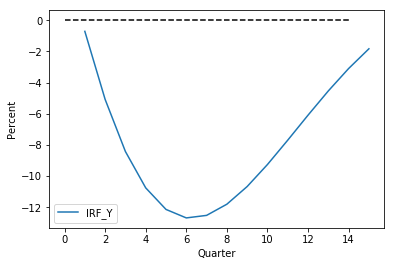

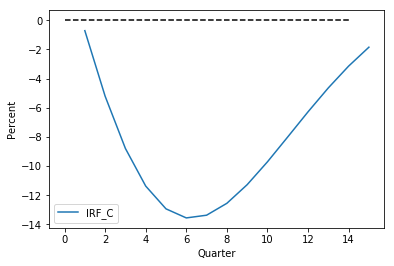

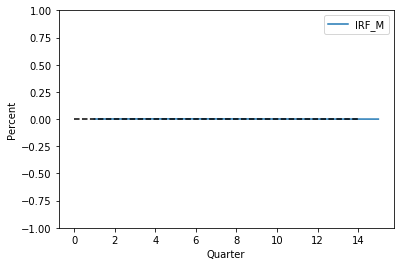

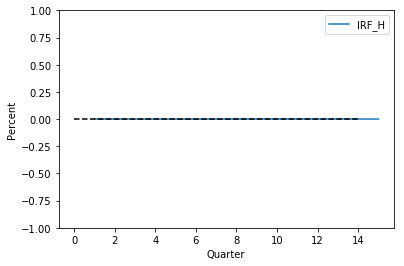

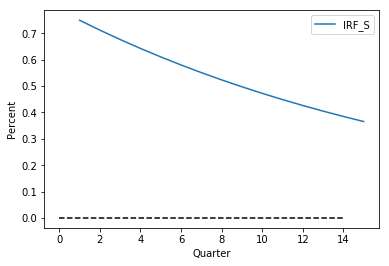

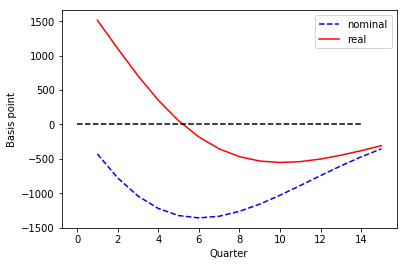

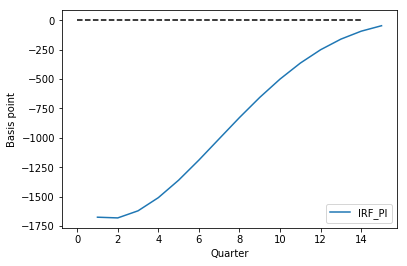

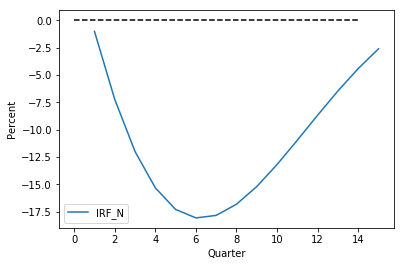

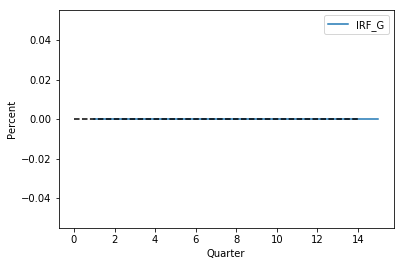

In [7]:
# Productivity Shock

#EX2SS['par']['aggrshock']           = 'MP'
#EX2SS['par']['rhoS']    = 0.0      # Persistence of variance
#EX2SS['par']['sigmaS']  = 0.001    # STD of variance shocks

EX2SS['par']['aggrshock']           = 'TFP'
EX2SS['par']['rhoS']    = 0.95
EX2SS['par']['sigmaS']  = 0.0075
    
#EX2SS['par']['aggrshock']           = 'Uncertainty'
#EX2SS['par']['rhoS']    = 0.84    # Persistence of variance
#EX2SS['par']['sigmaS']  = 0.54    # STD of variance shocks



SGUresult=SGU_solver(SR['Xss'],SR['Yss'],SR['Gamma_state'],SR['Gamma_control'],SR['InvGamma'],SR['Copula'],
                         SR['par'],SR['mpar'],SR['grid'],SR['targets'],SR['P_H'],SR['aggrshock'],SR['oc'])

plot_IRF(SR['mpar'],SR['par'],SGUresult['gx'],SGUresult['hx'],SR['joint_distr'],
             SR['Gamma_state'],SR['grid'],SR['targets'],SR['os'],SR['oc'],SR['Output'])

In [8]:
# # Uncertainty Shock


# ## EX2SS.p is the information in the stationary equilibrium (20: the number of illiquid and liquid weath grids )
# EX2SS=pickle.load(open("EX2SS.p", "rb"))

# #EX2SS['par']['aggrshock']           = 'MP'
# #EX2SS['par']['rhoS']    = 0.0      # Persistence of variance
# #EX2SS['par']['sigmaS']  = 0.001    # STD of variance shocks

# #EX2SS['par']['aggrshock']           = 'TFP'
# #EX2SS['par']['rhoS']    = 0.95
# #EX2SS['par']['sigmaS']  = 0.0075
    
# EX2SS['par']['aggrshock']           = 'Uncertainty'
# EX2SS['par']['rhoS']    = 0.84    # Persistence of variance
# EX2SS['par']['sigmaS']  = 0.54    # STD of variance shocks

# SGUresult=SGU_solver(SR['Xss'],SR['Yss'],SR['Gamma_state'],SR['Gamma_control'],SR['InvGamma'],SR['Copula'],
#                          SR['par'],SR['mpar'],SR['grid'],SR['targets'],SR['P_H'],SR['aggrshock'],SR['oc'])

# plot_IRF(SR['mpar'],SR['par'],SGUresult['gx'],SGUresult['hx'],SR['joint_distr'],
#              SR['Gamma_state'],SR['grid'],SR['targets'],SR['os'],SR['oc'],SR['Output'])

### References

<div class="cite2c-biblio"></div>